In [4]:
import geopandas as gpd
import fiona
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
import numpy as np
from math import sin, cos, sqrt, atan2, radians

In [8]:
#create a list of layers with in a file geodatabase 
layerlist = fiona.listlayers('./Schienennetz_LV03_20171210.gdb')
#print(layerlist)
netzknoten = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzknoten')
netzknoten = netzknoten.to_crs(epsg = 4326)
display(netzknoten.head())
netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')
#display(netzsegment.head())

,xtf_id,Betriebspunkt_Nummer,Betriebspunkt_Name,Betriebspunkt_Abkuerzung,Betriebspunkt_DatenherrAbkuer,BeginnGueltigkeit,EndeGueltigkeit,BearbeitungsDatum,Stand,rUebergeordnet,geometry
0,ch14uvag00092584,8580567,"Wabern, Eichholz",None,None,2014-10-01T00:00:00,None,2017-12-12T00:00:00,2017-12-10T00:00:00,None,POINT (7.45160 46.92866)
1,ch14uvag00092599,8590023,"Bern, Sandrain",None,None,2014-10-01T00:00:00,None,2017-12-12T00:00:00,2017-12-10T00:00:00,None,POINT (7.44513 46.93168)
2,ch14uvag00092576,8588779,"Basel, Rheingasse",None,None,2014-10-01T00:00:00,None,2017-12-12T00:00:00,2017-12-10T00:00:00,None,POINT (7.59164 47.56102)
3,ch14uvag00092992,8594239,"Zürich, Schiffbau",None,None,2014-10-01T00:00:00,None,2017-12-12T00:00:00,2017-12-10T00:00:00,None,POINT (8.51977 47.38792)
4,ch14uvag00092591,8590020,"Bern, Kursaal",None,None,2014-10-01T00:00:00,None,2017-12-12T00:00:00,2017-12-10T00:00:00,None,POINT (7.44961 46.95291)


In [94]:
G = nx.Graph()
for index, row in netzknoten.iterrows():
    G.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    G.add_edge(row.rAnfangsknoten, row.rEndknoten)

degree_sequence = [d for n, d in G.degree()]
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))

#Remove nodes which are not connected to any other node (degree = 0)
nodes = G.nodes()
to_delete = []
for n in nodes:
    if G.degree(n) == 0:
        to_delete.append(n)
for n in to_delete:
    
    G.remove_node(n)

degree_sequence = [d for n, d in G.degree()]
print("After removing zero degree nodes:")
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))

Lowest degree in Network=  0
Amount of Nodes in the Network 3190
After removing zero degree nodes:
Lowest degree in Network=  1
Amount of Nodes in the Network 3186


In [95]:
#Function to calculate the distance between two coordinate points
def calculate_distance(x1,y1,x2,y2):
    # approximate radius of earth in km
    R = 6373.0
    lon1 = radians(x1)
    lat1 = radians(y1)
       
    lon2 = radians(x2)
    lat2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance
    
def merge_close_nodes(G, merge_distance):
    temp = G.copy()
    node_list = temp.nodes()
    geometries = nx.get_node_attributes(G, "geometry")
    names = nx.get_node_attributes(G, "name")
    
    for node1 in node_list:
        if node1 in G.nodes():
            close_list = []
            edge_list = []
            #node1_edges = G.edges(node1)    -> (node1, node2) not in node1_edges
            for node2 in node_list:
                if node2 in G.nodes():
                    dist = calculate_distance(geometries[node1].x,geometries[node1].y, geometries[node2].x,geometries[node2].y)
                    if node1 != node2 and dist <= merge_distance and not nx.has_path(G, node1, node2):
                        close_list.append(node2)

            for merge_node in close_list:
                if G.has_node(merge_node):
                    edges = G.edges(merge_node)
                    for edge in edges:
                        edge_list.append(edge[1])
                    G.remove_node(merge_node)
                    print("removed node: ", names[merge_node])
            for to in edge_list:
                G.add_edge(node1,to)
                print("added edge from" + names[node1] + " to " + names[to])
   
            
    
    
    

In [96]:
merge_close_nodes(G, 0.3)


removed node:  Zürich Altstetten
removed node:  Zürich Altstetten Süd (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Zürich Altstetten Süd (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Einfang (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Urdorf
added edge fromZürich Altstetten, Bahnhof N to Zürich Altstetten Ost (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Zürich Mülligen
added edge fromZürich Altstetten, Bahnhof N to Zürich Herdern Abstellgruppe
added edge fromZürich Altstetten, Bahnhof N to Zürich Hauptwerkstätte
added edge fromZürich Altstetten, Bahnhof N to Zürich Altstetten Nord (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Zürich Vorbahnhof West
removed node:  Bern
added edge fromBern RBS to Bern JKLM
added edge fromBern RBS to Bern Henkerbrünnli
added edge fromBern RBS to Bern Weyermannshaus (Spw)
added edge fromBern RBS to Bern Wyler
removed node:  Basel Dreispitz
removed node:  Ruchfeld
added edge fromBasel, Dreispitz Kantonsgrenze to B

In [97]:
degree_sequence = [d for n, d in G.degree()]
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))


Lowest degree in Network=  1
Amount of Nodes in the Network 3146


In [98]:
#Some figures for the network: average degree <k>, global clustering coefficient C, assortativity etc.
degree_sequence = [d for n, d in G.degree()]

average_degree = sum(degree_sequence)/len(degree_sequence)
print("average degree ⟨k⟩ =",average_degree)

C = sum(nx.clustering(G).values())/len(nx.clustering(G).values())
print("global clustering C=", C)

assortativity = nx.degree_assortativity_coefficient(G)
print("assortativity=",assortativity)

print("number of connected components= ", nx.number_connected_components(G))

largest_cc = max(nx.connected_components(G), key=len)
number_largest_cc = len(largest_cc) 
number_nodes = len(G.nodes())
print("Amount of nodes in the giant component: ", number_largest_cc)
print("Relative size of the giant component to the full network =", number_largest_cc/number_nodes)

average degree ⟨k⟩ = 2.130324221233312
global clustering C= 0.01571711117165664
assortativity= 0.14188871929561872
number of connected components=  5
Amount of nodes in the giant component:  3116
Relative size of the giant component to the full network = 0.9904640813731723


[0, 206, 2455, 390, 73, 16, 3, 1, 0, 1, 1]


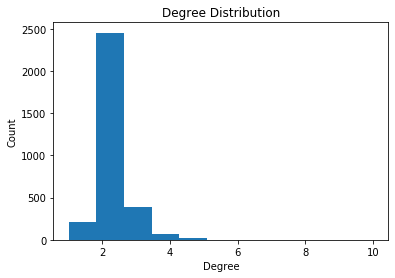

In [99]:
#Degree Distribution of the network
hist = nx.degree_histogram(G)
print(hist)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.hist(degree_sequence, bins = len(hist))
                     
plt.show()

In [143]:

G2 = nx.Graph()

for index, row in netzknoten.iterrows():
    if row.xtf_id in G.nodes(): 
        G2.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    if (row.rAnfangsknoten, row.rEndknoten) in G.edges() or (row.rEndknoten,row.rAnfangsknoten) in G.edges():
        
        G2.add_edge(row.rAnfangsknoten, row.rEndknoten)


In [109]:
#Centralities  (Do we need the correlations between them??)
degree = sorted(nx.degree_centrality(G).values(), reverse =True)
closeness = sorted(nx.closeness_centrality(G).values(), reverse =True)
betweenness = sorted(nx.betweenness_centrality(G).values(), reverse =True)
eigenvector = sorted(nx.eigenvector_centrality(G).values(), reverse =True)

print(max(degree))
print(max(closeness))
print(max(betweenness))
print(max(eigenvector))

0.0031796502384737677
0.02108746672126433
0.4051446623379526
0.413609534546098


In [169]:
def random_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    while nx.number_of_nodes(temp) > 1:
        node_list = []
        for n in temp.nodes():
            node_list.append(n)
        to_delete = random.choice(node_list)
        temp.remove_node(to_delete)
        
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
        
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Random attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()
       
def targeted_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    node_degrees = nx.degree_centrality(temp)
    sorted_node_degrees = sorted(temp.nodes(), key=lambda n: node_degrees[n])
    while nx.number_of_nodes(temp) > 1:
        temp.remove_node(sorted_node_degrees.pop())
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Targeted attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()

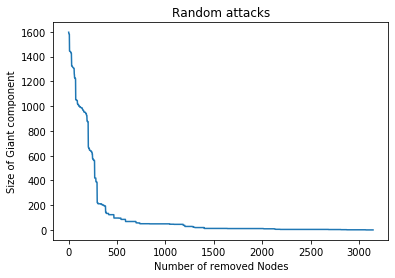

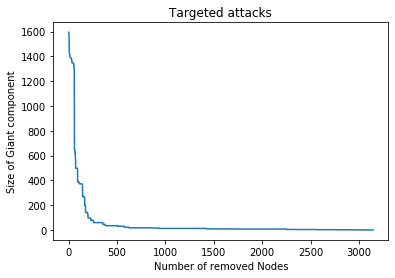

In [170]:
#Incluence of Random or targeted attacks on the remaining size of the Giant component

#Here we could think about using other attack strategies and other dependent variables

random_attacks(G2)
targeted_attacks(G2)

In [165]:
 a = ["ch14uvag00090163", "ch14uvag00089804","ch14uvag00093119", "ch14uvag00093120", "ch14uvag00066100", "ch14uvag00165821","ch14uvag00089645"]
#for n in G.nodes:
#    if n not in a:
 #       print(names[n])
 #   print(n)
print(G.nodes())
print(list(G.nodes()))

KeyError: 222